# Style Transfer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving 640px-Tuebingen_Neckarfront.jpg to 640px-Tuebingen_Neckarfront.jpg

Upload Style Image


Saving download.jpg to download.jpg
Content Path: <_io.BytesIO object at 0x79e2558ee160>
Style Path: <_io.BytesIO object at 0x79e328f349f0>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


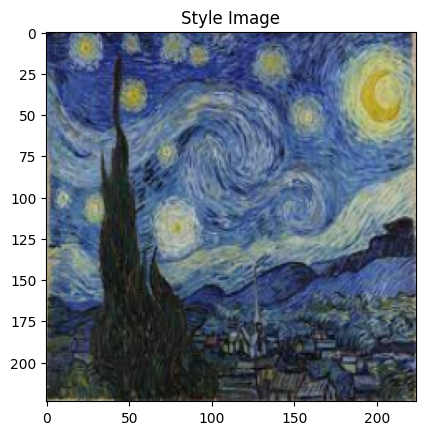

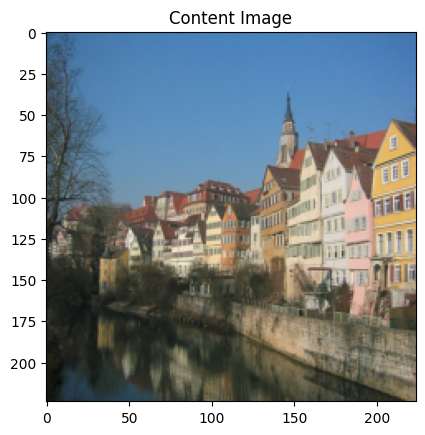

In [4]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Choose the layers to use for style and content transfer
content_layers = [vgg_names.index('conv4_2')]
style_layers = [vgg_names.index('conv1_1'), vgg_names.index('conv2_1'), vgg_names.index('conv3_1'),
                vgg_names.index('conv4_1'), vgg_names.index('conv5_1')]
# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
content_model = VGGIntermediate(requested=content_layers).to(device).eval()
style_model = VGGIntermediate(requested=style_layers).to(device).eval()
generative_model = VGGIntermediate(requested=content_layers + style_layers).to(device).eval()
# Cache the outputs of the content and style layers for their respective images
with torch.no_grad():
  saved_content_outputs = content_model(content_image)
  saved_style_outputs = style_model(style_image)
saved_style_outputs.keys()

<ipython-input-5-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-5-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior

dict_keys([0, 5, 10, 17, 24])

In [7]:
def gram_matrix(input):
  b, c, h, w = input.size()
  feature_map = input.view(b*c, h*w)
  gram = torch.matmul(feature_map, feature_map.transpose(0,1))
  return gram, c, h*w

class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    loss = F.mse_loss(input, self.target)
    return loss

class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target)[0].detach()

  def forward(self, input):
    input_gram, N, M = gram_matrix(input)
    loss = F.mse_loss(input_gram, self.target)
    loss /= 4 * (N**2) * (M**2)
    return loss

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison
conv4_2_content_loss = ContentLoss(target=saved_content_outputs[19].detach())
# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
conv1_1_style_loss = StyleLoss(target=saved_style_outputs[0].detach())
conv2_1_style_loss = StyleLoss(target=saved_style_outputs[5].detach())
conv3_1_style_loss = StyleLoss(target=saved_style_outputs[10].detach())
conv4_1_style_loss = StyleLoss(target=saved_style_outputs[17].detach())
conv5_1_style_loss = StyleLoss(target=saved_style_outputs[24].detach())

Epoch: 50 Content Loss: 70.485085 Style Loss : 0.000055
Epoch: 100 Content Loss: 52.939537 Style Loss : 0.000107
Epoch: 150 Content Loss: 94.240753 Style Loss : 0.000542
Epoch: 200 Content Loss: 62.786663 Style Loss : 0.000074
Epoch: 250 Content Loss: 42.650898 Style Loss : 0.000024
Epoch: 300 Content Loss: 41.053333 Style Loss : 0.000024
Epoch: 350 Content Loss: 35.685520 Style Loss : 0.000019
Epoch: 400 Content Loss: 77.312027 Style Loss : 0.000356
Epoch: 450 Content Loss: 81.303543 Style Loss : 0.000461
Epoch: 500 Content Loss: 67.160843 Style Loss : 0.000141


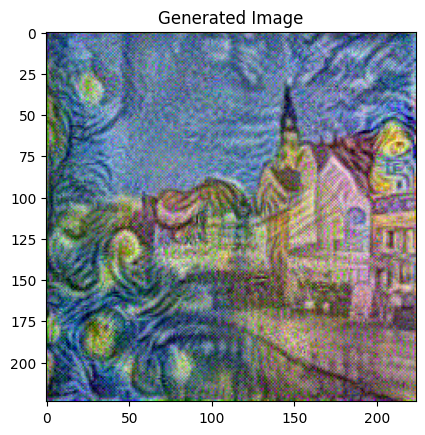

In [10]:
# Start with a copy of the content image
input_img = content_image.clone()
input_img.requires_grad_(True)
optimizer = optim.Adam(params=[input_img], lr=1e-1)
# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors
output_images = []

for epoch in range(500):
  with torch.no_grad():
    input_img.clamp_(0, 1)

  outputs = generative_model(input_img)
  optimizer.zero_grad()
  # Calculate content loss
  content_loss = conv4_2_content_loss(outputs[19])
  # Calculated style loss
  style_loss = 0
  style_loss += conv1_1_style_loss(outputs[0]) * 1/5
  style_loss += conv2_1_style_loss(outputs[5]) * 1/5
  style_loss += conv3_1_style_loss(outputs[10]) * 1/5
  style_loss += conv4_1_style_loss(outputs[17]) * 1/5
  style_loss += conv5_1_style_loss(outputs[24]) *1/5
  total_loss = 1 * content_loss + 1e6 * style_loss
  total_loss.backward()
  optimizer.step()

  if (epoch+1) % 50 == 0:
    print('Epoch: {:} Content Loss: {:4f} Style Loss : {:4f}'.format(epoch+1, content_loss.item(), style_loss.item()))
    output_images.append(input_img)


# Show the image
with torch.no_grad():
    input_img.clamp_(0, 1)
plt.figure()
display(input_img, title='Generated Image')